In [64]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as sio
import os
from einops import rearrange, reduce, repeat

plt.rcParams["font.family"] = "Times New Roman"

In [65]:
methods = [
    "EXP",
    "MTF_GLP_FS",
    "TV",
    "BDSD_PC",
    "CVPR19",
    "LRTCFPan",
    "PNN",
    "PanNet",
    "DiCNN",
    "FusionNet",
    "DCFNet",
    "LAGConv",
    "HMPNet",
    "CMT",
    "CANNet",
    "Proposed"
]
disp_names = {
    "MTF_GLP_FS": "MTF-GLP-FS",
    "BDSD_PC": "BDSD-PC",
    # "CANNet": "CANNet",
    "GT": "Ground Truth",
}
cols = 8
rows = 2

In [66]:
def load_mat_data(dir, methods, image_id):
    data = []
    for method in methods:
        
        if os.path.exists(os.path.join(dir, method, "results")):
            mat_file = os.path.join(dir, method, "results", f"output_mulExm_{image_id}.mat")
        else:
            mat_file = os.path.join(dir, method, f"output_mulExm_{image_id}.mat")
        sr = sio.loadmat(mat_file)["sr"]
        if sr.shape[0] == 1:
            sr = sr[0]
        data.append(sr)
    return np.array(data)

In [67]:
def to_rgb(x, tol_low=0.01, tol_high=0.99):
    # x: [b, h, w, c]
    b, h, w, c = x.shape
    if c == 4:
        x = x[:, :, :, [2, 1, 0]]
        c = 3
    elif c == 8:
        x = x[:, :, :, [4, 2, 1]]
        c = 3
    x = rearrange(x, "b h w c -> (b h w) c")
    x_sort = np.sort(x, axis=0)
    t_low = x_sort[int(tol_low * b * h * w), :]
    t_high = x_sort[int(tol_high * b * h * w), :]
    x = (x - t_low) / (t_high - t_low)
    x = np.clip(x, 0, 1)
    x = rearrange(x, "(b h w) c -> b h w c", b=b, h=h, w=w, c=c)
    
    return x

In [68]:
wv3_reduced = load_mat_data("WV3_Reduced", methods, 19)
wv3_gt = load_mat_data("WV3_Reduced", ["GT"], 19)
wv3_reduced = np.concatenate([wv3_reduced, wv3_gt], axis=0)

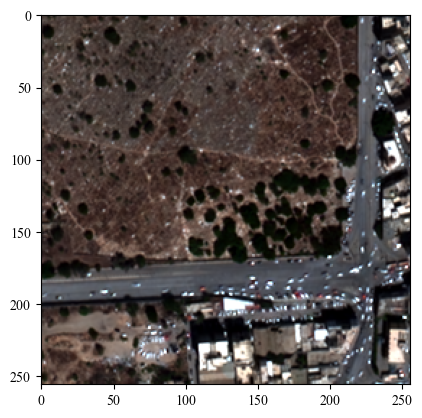

In [69]:
wv3_reduced_rgb = to_rgb(wv3_reduced)
plt.imshow(wv3_reduced_rgb[10])
plt.show()

In [70]:
# wv3_full = load_mat_data("WV3_Full", ["DiCNN"], 18)
# wv3_full_rgb = to_rgb(wv3_full)
# plt.figure(figsize=(10, 10))
# plt.imshow(wv3_full_rgb[0])

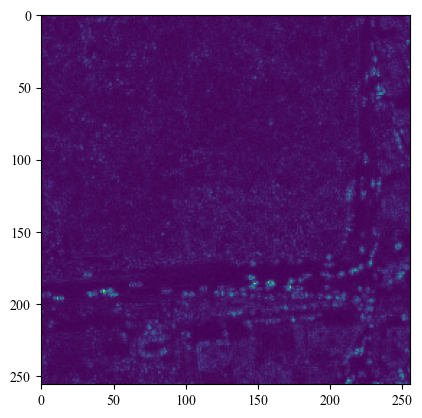

In [59]:
def make_aem(data, gt):
    return np.max(np.abs(data - gt), axis=-1, keepdims=False)

wv3_aem = make_aem(wv3_reduced, wv3_gt)
plt.imshow(wv3_aem[10])
plt.show()

In [60]:
# def make_reduced_plot(rgb, aem, methods, out_file, inset_pos, inset_origin):
#     rows = 2
#     cols = 8
#     fig, axs = plt.subplots(rows * 2, cols, figsize=(10, 5), constrained_layout=True)
#     norm = plt.Normalize(vmin=0, vmax=np.max(aem).item() / 2)
#     for i in range(rows * 2):
#         for j in range(cols):
#             ax = axs[i, j]
#             ax.axis("off")
#             ax.label_outer()
#             id = (i // 2) * cols + j
#             if id >= len(methods):
#                 continue
#             title = methods[id]
#             if i % 2 == 0:
#                 img = rgb[id]
#                 ax.set_title(disp_names.get(title, title))
#                 ax.imshow(img)
#             else:
#                 img = aem[id]
#                 ax.imshow(img, norm=norm)
#             size = img.shape[0]
#             axins = ax.inset_axes(
#                 inset_pos,
#                 xlim=(size * inset_origin[0], size * inset_origin[1]),
#                 ylim=(size * inset_origin[2], size * inset_origin[3]),
#                 xticks=[],
#                 yticks=[],
#             )
#             if i % 2 == 0:
#                 axins.imshow(img, origin="lower")
#             else:
#                 axins.imshow(img, origin="lower", norm=norm)
#             ax.indicate_inset_zoom(axins, edgecolor="white", alpha=1)

#             axins.spines["top"].set_color("white")
#             axins.spines["right"].set_color("white")
#             axins.spines["bottom"].set_color("white")
#             axins.spines["left"].set_color("white")

#     # fig.subplots_adjust(hspace=0.01, wspace=0.01)
#     # fig.tight_layout()
#     plt.savefig(out_file, bbox_inches="tight")
#     # plt.show()

def make_reduced_plot(rgb, aem, methods, out_file, inset_pos, inset_origin):
    rows = 2
    cols = 8
    fig, axs = plt.subplots(rows * 2, cols, figsize=(10, 5), constrained_layout=True)
    norm = plt.Normalize(vmin=0, vmax=np.max(aem).item() / 2)
    for i in range(rows * 2):
        for j in range(cols):
            ax = axs[i, j]
            ax.axis("off")
            ax.label_outer()
            id = (i // 2) * cols + j
            if id >= len(methods):
                continue
            title = methods[id]
            if i % 2 == 0:
                img = rgb[id]
                ax.set_title(disp_names.get(title, title))
                ax.imshow(img)
            else:
                img = aem[id]
                ax.imshow(img, norm=norm)
            size = img.shape[0]
            axins = ax.inset_axes(
                inset_pos,
                xlim=(size * inset_origin[0], size * inset_origin[1]),
                ylim=(size * inset_origin[3], size * inset_origin[2]),
                xticks=[],
                yticks=[],
            )
            if i % 2 == 0:
                axins.imshow(img, origin="lower")
            else:
                axins.imshow(img, origin="lower", norm=norm)
            
            axins.spines["top"].set_color("white")
            axins.spines["right"].set_color("white")
            axins.spines["bottom"].set_color("white")
            axins.spines["left"].set_color("white")

            rect = matplotlib.patches.Rectangle(
                (size * inset_origin[0], size * inset_origin[2]),
                size * (inset_origin[1] - inset_origin[0]),
                size * (inset_origin[1] - inset_origin[0]),
                linewidth=1,
                edgecolor="white",
                facecolor="none"
            )
            ax.add_patch(rect)

            src_corners = [
                (size * inset_origin[0], size * inset_origin[3]),  # 左下角
                (size * inset_origin[1], size * inset_origin[2]),  # 右上角
            ]
            dst_corners = [
                (inset_pos[0], inset_pos[1]),                       # 左下角
                (inset_pos[0] + inset_pos[2], inset_pos[1] + inset_pos[3]),  # 右上角
            ]

            for src, dst in zip(src_corners, dst_corners):
                line = matplotlib.lines.Line2D(
                    [src[0], dst[0] * size],  # x 坐标
                    [src[1], size - dst[1] * size],  # y 坐标
                    color="white",
                    linewidth=1,
                )
                ax.add_line(line)

    # fig.subplots_adjust(hspace=0.01, wspace=0.01)
    # fig.tight_layout()
    plt.savefig(out_file, bbox_inches="tight")
    # plt.show()
    
def make_full_plot(rgb, methods, out_file, inset_pos, inset_origin):
    fig, axs = plt.subplots(rows, cols, figsize=(10, 2.5), constrained_layout=True)
    for i in range(rows):
        for j in range(cols):
            ax = axs[i, j]
            ax.axis("off")
            ax.label_outer()
            id = i * cols + j
            if id >= len(methods):
                continue
            title = methods[id]
            img = rgb[id]
            ax.set_title(disp_names.get(title, title))
            ax.imshow(img)
            size = img.shape[0]
            axins = ax.inset_axes(
                inset_pos,
                xlim=(size * inset_origin[0], size * inset_origin[1]),
                ylim=(size * inset_origin[2], size * inset_origin[3]),
                xticks=[],
                yticks=[],
            )
            axins.imshow(img, origin="lower")
            ax.indicate_inset_zoom(axins, edgecolor="white", alpha=1)

            axins.spines["top"].set_color("white")
            axins.spines["right"].set_color("white")
            axins.spines["bottom"].set_color("white")
            axins.spines["left"].set_color("white")

    # fig.subplots_adjust(hspace=0.01, wspace=0.01)
    # fig.tight_layout()
    plt.savefig(out_file, bbox_inches="tight")

In [61]:
def load_and_plot_reduced(dir, id, inset_pos, inset_origin):
    data = load_mat_data(dir, methods, id)
    gt = load_mat_data(dir, ["GT"], id)
    data = np.concatenate([data, gt], axis=0)
    rgb = to_rgb(data)
    aem = make_aem(data, gt)
    out_file = f"{dir}{id}.pdf"
    make_reduced_plot(rgb, aem, methods + ["GT"], out_file, inset_pos, inset_origin)

def load_and_plot_full(dir, id, inset_pos, inset_origin):
    data = load_mat_data(dir, methods, id)
    rgb = to_rgb(data)
    out_file = f"{dir}{id}.pdf"
    make_full_plot(rgb, methods, out_file, inset_pos, inset_origin)

In [62]:
# load_and_plot_reduced(
#     "WV3_Reduced",
#     12,
#     [0.5, 0.03, 0.47, 0.47],
#     [0.6, 0.8, 0.1, 0.3],
# )

In [63]:
# load_and_plot_full("WV3_Full", 18, [0.03, 0.03, 0.47, 0.47], [0.6, 0.7, 0.5, 0.6])

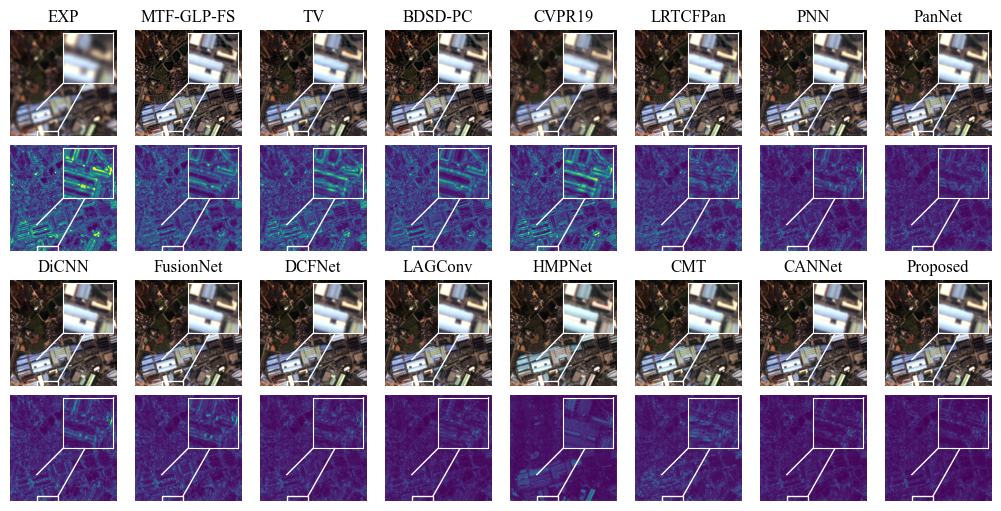

In [71]:
load_and_plot_reduced(
    "GF2_Reduced",
    8,
    [0.5, 0.5, 0.47, 0.47],
    [0.25, 0.45, 0.95, 0.75],
)

In [14]:
# load_and_plot_reduced(
#     "QB_Reduced",
#     8,
#     [0.5, 0.5, 0.47, 0.47],
#     [0.75, 0.95, 0.8, 0.6],
# )

In [15]:
# load_and_plot_full(
#     "GF2_Full",
#     18,
#     [0.5, 0.5, 0.47, 0.47],
#     [0.7, 0.8, 0.8, 0.7],
# )

In [27]:
# load_and_plot_full(
#     "QB_Full",
#     6,
#     [0.5, 0.5, 0.47, 0.47],
#     [0.65, 0.75, 0.8, 0.7],
# )